# Outlier 고치기

## 기존 상태 확인

In [1]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 54.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]


[INFO] Processing row=0, video=0_RAW_DATA/AI_dataset/N01/N01_Treatment/Biceps Curl1.MP4


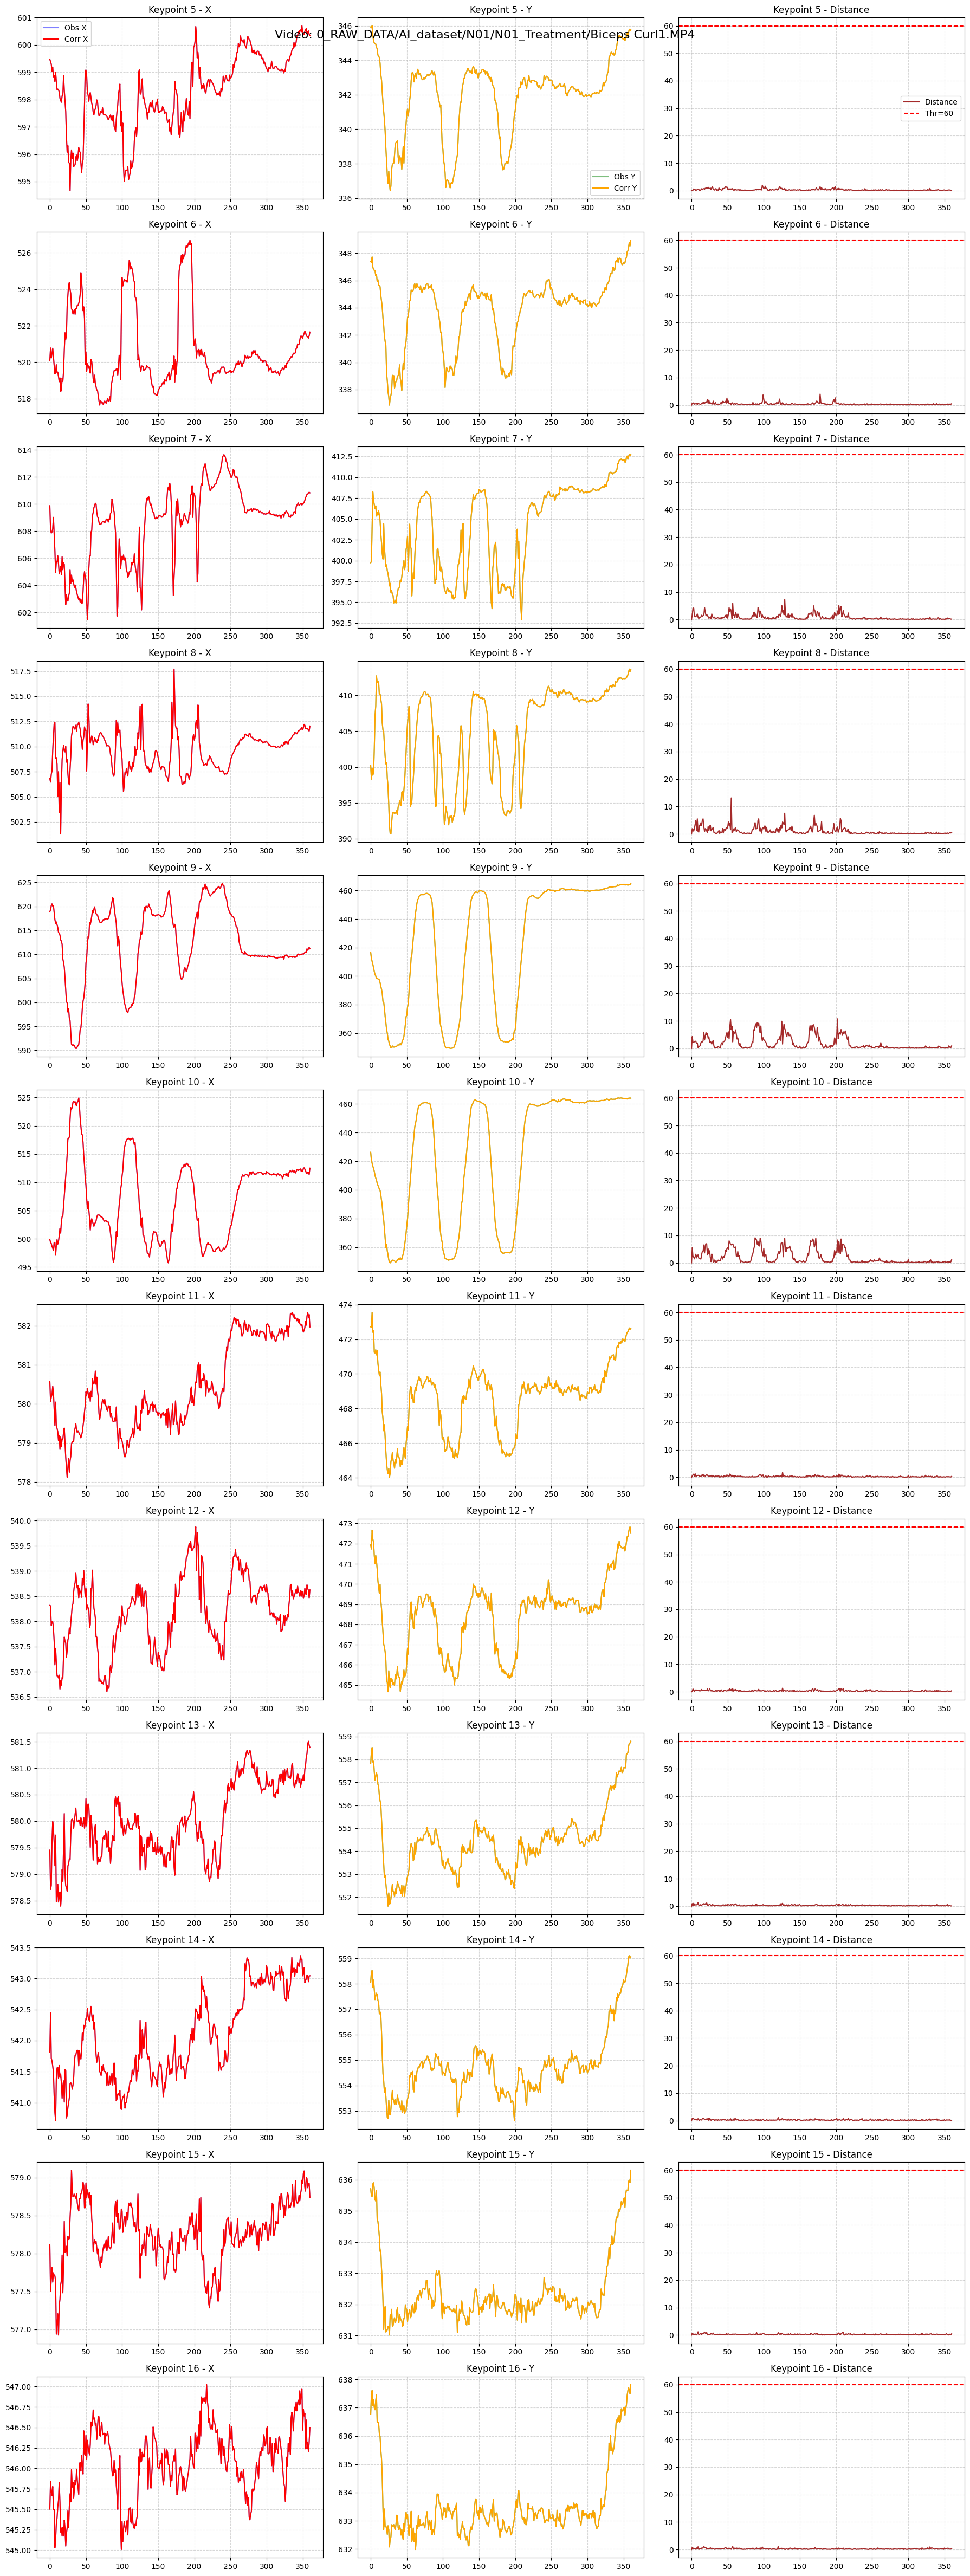

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 보간 함수 (네가 만든 것)
# -----------------------------
def interpolate_with_last_valid(coords, kp, thr_d=150):
    """
    Outlier → 가장 최근 정상값(last valid)으로 보간
    - coords: (T, J, 2)
    - kp: keypoint index
    - thr_d: 거리 threshold
    """
    x = coords[:, kp, 0].copy()
    y = coords[:, kp, 1].copy()
    dist = np.zeros(len(x))
    outliers = []

    # 기준 좌표 = 첫 frame
    x_ref, y_ref = x[0], y[0]

    for t in range(len(x)):
        d = np.sqrt((x[t] - x_ref) ** 2 + (y[t] - y_ref) ** 2)
        dist[t] = d

        if d > thr_d:
            # Outlier → 보간 (가장 최근 정상값 복사)
            x[t] = x_ref
            y[t] = y_ref
            outliers.append(t)
        else:
            # 정상 → 기준 좌표 갱신
            x_ref, y_ref = x[t], y[t]

    return x, y, dist, np.array(outliers, dtype=int)

# -----------------------------
# JSON 불러오기
# -----------------------------
def load_keypoints(json_dir):
    coords = []
    files = sorted(os.listdir(json_dir))
    for fname in files:
        if not fname.endswith(".json"):
            continue
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
        kps = np.array(data["instance_info"][0]["keypoints"])  # (17, 2)
        coords.append(kps)
    return np.array(coords)  # (T, 17, 2)

# -----------------------------
# 메인 함수: 특정 행 선택해서 그래프 그리기
# -----------------------------
def plot_keypoints_from_metadata(idx, thr_d=150):
    BASE_DIR = "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    META_PATH = os.path.join(BASE_DIR, "data/metadata.csv")

    df_meta = pd.read_csv(META_PATH)
    row = df_meta.iloc[idx]

    # 영상 제목 (video_path)
    video_name = row["video_path"]
    print(f"[INFO] Processing row={idx}, video={video_name}")

    # JSON 경로 만들기
    json_rel_path = row["keypoints_path"]
    json_dir = os.path.join(BASE_DIR, "data", json_rel_path)

    coords = load_keypoints(json_dir)

    # -----------------------------
    # 모든 keypoints (5~17)에 대해 Plot
    # -----------------------------
    T, J, _ = coords.shape
    kp_range = range(5, J)  # shoulder~ankle

    ncols = 3   # X, Y, Distance
    nrows = len(kp_range)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4*nrows))

    for row_i, kp in enumerate(kp_range):
        x_corr, y_corr, dist, outliers = interpolate_with_last_valid(coords, kp, thr_d=thr_d)

        # X 좌표
        ax = axes[row_i, 0]
        ax.plot(coords[:, kp, 0], label="Obs X", color="blue", alpha=0.5)
        ax.plot(x_corr, label="Corr X", color="red")
        if len(outliers) > 0:
            ax.scatter(outliers, coords[outliers, kp, 0], color="black", marker="x", label="Outliers")
        ax.set_title(f"Keypoint {kp} - X")
        ax.grid(True, linestyle="--", alpha=0.5)

        # Y 좌표
        ax = axes[row_i, 1]
        ax.plot(coords[:, kp, 1], label="Obs Y", color="green", alpha=0.5)
        ax.plot(y_corr, label="Corr Y", color="orange")
        if len(outliers) > 0:
            ax.scatter(outliers, coords[outliers, kp, 1], color="black", marker="x", label="Outliers")
        ax.set_title(f"Keypoint {kp} - Y")
        ax.grid(True, linestyle="--", alpha=0.5)

        # Distance
        ax = axes[row_i, 2]
        ax.plot(dist, label="Distance", color="brown")
        if len(outliers) > 0:
            ax.scatter(outliers, dist[outliers], color="red", marker="x")
        ax.axhline(thr_d, color="red", linestyle="--", label=f"Thr={thr_d}")
        ax.set_title(f"Keypoint {kp} - Distance")
        ax.grid(True, linestyle="--", alpha=0.5)

    # 범례는 첫 줄만 표시
    axes[0, 0].legend()
    axes[0, 1].legend()
    axes[0, 2].legend()

    fig.suptitle(f"Video: {video_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 실행 예시
# -----------------------------
if __name__ == "__main__":
    plot_keypoints_from_metadata(idx=0, thr_d=60)  # 첫 번째 영상 확인


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import json
import cv2
import numpy as np
import pandas as pd

# -----------------------------
# 기본 경로
# -----------------------------
BASE_DIR = "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
META_PATH = os.path.join(BASE_DIR, "data/metadata.csv")
SAVE_BASE = os.path.join(BASE_DIR, "4_interp_data/JSON")

# -----------------------------
# BBOX 계산 (얼굴 제외, keypoints 5~16 사용)
# -----------------------------
def compute_bbox(kps):
    body = kps[5:17]  # shoulder~ankle
    x_min, y_min = body[:,0].min(), body[:,1].min()
    x_max, y_max = body[:,0].max(), body[:,1].max()
    return [float(x_min), float(y_min), float(x_max), float(y_max)]

# -----------------------------
# JSON 저장
# -----------------------------
def save_keypoints_as_json(coords, scores, save_dir, base_info=None):
    os.makedirs(save_dir, exist_ok=True)

    for t in range(len(coords)):
        kps = coords[t].tolist()
        scs = scores[t].tolist() if scores is not None else [1.0]*len(kps)

        bbox = compute_bbox(coords[t])

        data = {
            "frame_index": t,
            "instance_info": [
                {
                    "keypoints": kps,
                    "keypoint_scores": scs,
                    "bbox": [bbox],
                    "bbox_score": 1.0
                }
            ]
        }
        if base_info:
            data["meta_info"] = base_info

        out_path = os.path.join(save_dir, f"{t:06d}.json")
        with open(out_path, "w") as f:
            json.dump(data, f, indent=2)

# -----------------------------
# Overlay 확인
# -----------------------------
def visualize_overlay(frames_dir, coords, save_dir=None):
    frame_files = sorted(os.listdir(frames_dir))
    for t, fname in enumerate(frame_files):
        frame = cv2.imread(os.path.join(frames_dir, fname))
        pts = coords[t].astype(int)

        # keypoints
        for (x,y) in pts[5:]:  # 얼굴 제외
            cv2.circle(frame, (x,y), 4, (0,0,255), -1)

        # bbox
        x1,y1,x2,y2 = map(int, compute_bbox(pts))
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

        cv2.imshow("Overlay", frame)
        key = cv2.waitKey(50)  # 빠르게 재생 (20fps 정도)
        if key == ord("q"): break

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            cv2.imwrite(os.path.join(save_dir, fname), frame)

    cv2.destroyAllWindows()

# -----------------------------
# 실행 예시
# -----------------------------
if __name__ == "__main__":
    df_meta = pd.read_csv(META_PATH)
    row = df_meta.iloc[0]

    video_name = os.path.basename(row["video_path"])
    frame_dir = os.path.join(BASE_DIR, "data", row["frame_path"])
    json_dir  = os.path.join(BASE_DIR, "data", row["keypoints_path"])

    # coords 불러오기
    coords = []
    scores = []
    files = sorted(os.listdir(json_dir))
    for fname in files:
        if not fname.endswith(".json"): continue
        with open(os.path.join(json_dir, fname), "r") as f:
            data = json.load(f)
        kps = np.array(data["instance_info"][0]["keypoints"])
        scs = np.array(data["instance_info"][0].get("keypoint_scores", [1.0]*len(kps)))
        coords.append(kps)
        scores.append(scs)

    coords = np.array(coords)
    scores = np.array(scores)

    # 보간 결과 저장 (여기서는 그대로 저장)
    save_dir = os.path.join(SAVE_BASE, os.path.basename(json_dir))
    save_keypoints_as_json(coords, scores, save_dir)

    # frame overlay 확인
    visualize_overlay(frame_dir, coords)


: 

: 

: 